In [44]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime, timedelta
import gensim
import negation_data
import keras.backend as K
import tensorflow as tf

dtype='float16'
K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4) 


data_root_folder = 'data'
data_raw_folder = data_root_folder + '/raw'
data_processed_folder = data_root_folder + '/processed'
data_cached_folder= data_root_folder + '/cached'
datasets_folder = data_root_folder + '/datasets'
results_folder='data/results/seen_diseases'


# hyper params chosen when producing the datasets
embedding_dimension=300 # size of token vectors
max_document_length=300 # truncate sentences longer than this
num_token_types = 71333 # magic number, it is determined by the tokeniser used to produce the dataset eg
#tokeniser=get_tokeniser('negation_detection_sentences_experiment_%s_train.txt' % experiment)
#num_token_types=len(tokeniser.word_index)

# 8=referral
# 9=primary

number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0
dataset='test' # dev or test
experiment='pri_ref'

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: '1-never diagnosed',
    1: '2-prior to diagnostic window',
    2: '3-after diagnostic window',
    3: '4-during diagnostic window'}

In [2]:
# load persisted datasets
def load_word2vec_new():
    return gensim.models.KeyedVectors.load_word2vec_format('data/processed/vec_sg_20180321.txt', binary=False, unicode_errors='ignore')

def load_dataset(experiment=8,dataset='train',number_of_classes=4,window_before_diagnosis=8,window_after_diagnosis=0):
    x_1=np.load(datasets_folder+'/x_%s_1_exp_%s.npy' % (dataset,experiment))
    x_2=np.load(datasets_folder+'/x_%s_2_exp_%s.npy' % (dataset,experiment))
    y=np.load(datasets_folder+'/y_%s_exp_%s_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,experiment,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    return x_1,x_2,y

def get_tokeniser():
    def get_sentences_generator():
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_8_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_9_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
    tokeniser=Tokenizer()
    tokeniser.fit_on_texts(get_sentences_generator())
    return tokeniser

tokeniser=get_tokeniser()

def merge_datasets(exp_8,exp_9):
    stacks= [np.vstack([exp_8[i],exp_9[i]]) for i in range(0,3)]
    return (stacks[0],stacks[1],stacks[2])

x_train,x_train_2,y_train=merge_datasets(
                            load_dataset(8,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )
x_dev,x_dev_2,y_dev=merge_datasets(
                            load_dataset(8,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )


sg=load_word2vec_new() # needed because persisted datasets are in embedding (integer) format


/home/noel/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:28: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
x_train.shape,y_train.shape

((520728, 300), (520728, 4))

In [4]:
sum(y_dev)

array([24037,  2267, 38486,   344])

In [5]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle

def evaluate(y_true, y_pred, plot=True, title='Receiver operating characteristic'):
    
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=list()
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
            
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    if(len(drop_classes)!=0):
        print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot:
        # Plot all ROC curves
        plt.figure()
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='{0} area={1:0.2f}'
                     ''.format(class_labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc

In [6]:
def make_model_cnn_funnel(x_train, x_train_2,y_train,word2vec
                              ,hyperparameters
                              ,gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
    from keras.layers.merge import Concatenate
    from keras.datasets import imdb
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers
    import tensorflow as tf

     # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(
        num_token_types+1
        , embedding_dimension
        , input_length=max_document_length
        , trainable=False
        , mask_zero=False)# CONV doesnt support masking

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')

    z = main_input

    # convert token integers to word embeddings
    z = embedding_layer(z)
    
    # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    z = Convolution1D(hyperparameters['num_filters'], hyperparameters['filter_size'], activation='relu')(z)
    z = MaxPooling1D(hyperparameters['max_pooling_size'])(z)
    z = Dropout(hyperparameters['dropout_prob'])(z)
    z = Convolution1D(int(hyperparameters['num_filters']/2), hyperparameters['filter_size'], activation='relu')(z)
    z = MaxPooling1D(hyperparameters['max_pooling_size'])(z)
    z = Dropout(hyperparameters['dropout_prob'])(z)
    z = Convolution1D(int(hyperparameters['num_filters']/3), hyperparameters['filter_size'], activation='relu')(z)
    z = Flatten()(z)

    z = Dense(hyperparameters['hidden_dims'], activation='relu',kernel_regularizer=regularizers.l2(hyperparameters['l2_regulariser']))(z)
    model_output = Dense(num_classes, activation="softmax")(z)


    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            cpu_model.layers[1].set_weights([embedding_matrix])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix])
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model

def make_model_bilstm(x_train, x_train_2,y_train,word2vec
                          ,hyperparameters           
                         , gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense,CuDNNLSTM, LSTM,Dropout,Bidirectional, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Lambda,RepeatVector, Multiply
    from keras.layers.merge import Concatenate
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers
    


    # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(
        num_token_types+1
        , embedding_dimension
        , input_length=max_document_length
        , trainable=False
        , mask_zero=False)# CUDNNLSTM doesnt support masking

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')

    z = main_input

    # convert token integers to word embeddings
    z = embedding_layer(z)
    
    # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    # BILSTM layer
    z = Bidirectional(CuDNNLSTM(hyperparameters['hidden_dims'],return_sequences=True))(z)
    z = Lambda(lambda x: K.max(x,axis=1),name='max_pooling')(z)
    z = Dropout(hyperparameters['dropout_prob'])(z)

    model_output = Dense(num_classes, activation="softmax")(z)

    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            embedding_layer.set_weights([embedding_matrix.astype(dtype)])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix.astype(dtype)])
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model
    
def make_model_cnn_hierarchical(
                                x_train, x_train_2,y_train,word2vec
                                , hyperparameters
                                , gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Lambda,RepeatVector, Multiply
    from keras.layers.merge import Concatenate
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers


    # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(num_token_types+1,embedding_dimension, input_length=max_document_length,trainable=False)

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')
    
    
    z = main_input
    
    # convert token integers to word embeddings
    z = embedding_layer(main_input)

     # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    z = Convolution1D(hyperparameters['num_filters'], hyperparameters['filter_size'], activation='relu',strides=1, padding='same')(z)
    max_pool_1 = Lambda(lambda x: K.max(x,axis=1),name='u1')(z)

    z = Convolution1D(hyperparameters['num_filters'], hyperparameters['filter_size'], activation='relu',strides=1, padding='same')(z)
    max_pool_2 = Lambda(lambda x: K.max(x,axis=1),name='u2')(z)

    z = Convolution1D(hyperparameters['num_filters'], hyperparameters['filter_size'], activation='relu',strides=1, padding='same')(z)
    max_pool_3 = Lambda(lambda x: K.max(x,axis=1),name='u3')(z)
    
    z = Convolution1D(hyperparameters['num_filters'], hyperparameters['filter_size'], activation='relu',strides=1, padding='same')(z)
    max_pool_4 = Lambda(lambda x: K.max(x,axis=1),name='u4')(z)
 
    z = Concatenate(axis=1)([max_pool_1,max_pool_2,max_pool_3,max_pool_4])
    
    z = Dense(hyperparameters['hidden_dims'])(z)

    model_output = Dense(num_classes, activation="softmax")(z)

    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            embedding_layer.set_weights([embedding_matrix.astype(dtype)])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix.astype(dtype)])
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model
  
def make_model_cnn_flat(x_train, x_train_2,y_train,word2vec
                 , hyperparameters
                 , gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Lambda,RepeatVector, Multiply
    from keras.layers.merge import Concatenate
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers


    # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(num_token_types+1,embedding_dimension, input_length=max_document_length,trainable=False)

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')
    
    z = main_input

    # convert token integers to word embeddings
    z = embedding_layer(z)
    
    # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    conv_blocks = []
    for sz in hyperparameters['filter_sizes']:
        conv = Convolution1D(filters=hyperparameters['num_filters'],
                             kernel_size=sz,
                             padding="valid",
                             activation="relu",
                             strides=1)(z)
        conv = MaxPooling1D(pool_size=hyperparameters['pool_size'])(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dropout(hyperparameters['dropout_prob'])(z)
    
    z = Dense(hyperparameters['hidden_dims'], activation="relu",kernel_regularizer=regularizers.l2(hyperparameters['l2_regulariser']))(z)
    model_output = Dense(num_classes, activation="softmax")(z)

    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            embedding_layer.set_weights([embedding_matrix.astype(dtype)])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix.astype(dtype)])
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters['optimizer'],metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model

# tuned hyperparameters for each model

In [55]:
model_hyperparameters={
     'cnn_funnel':{ # tuned
        'num_filters':250
        , 'dropout_prob':0.2
        , 'filter_size':5
        , 'max_pooling_size':5
        , 'l2_regulariser':0.01
        , 'optimizer':keras.optimizers.Adam()
        , 'hidden_dims':80
        , 'batch_size':256
        , 'epochs':7
        , 'create_model_function':make_model_cnn_funnel
    } ,
    'cnn_flat':{ # tuned
        'filter_sizes':(3,4,5)
        , 'num_filters':100
        , 'dropout_prob':0.2
        , 'hidden_dims':80
        , 'pool_size':21
        , 'l2_regulariser':0.01
        , 'optimizer':keras.optimizers.Adam()
        , 'epochs':5
        , 'batch_size':256
        , 'create_model_function':make_model_cnn_flat  
    }, 'bilstm':{ # tuned
        'dropout_prob':0.5
        , 'hidden_dims':80
        , 'optimizer':keras.optimizers.Adam()
        , 'batch_size':256
        , 'epochs':20
        , 'create_model_function':make_model_bilstm     
    }, 'cnn_hierarchical':{ # tuned
        'filter_size':3
        , 'num_filters':150
        , 'optimizer':keras.optimizers.Adam(lr=0.0001)
        , 'hidden_dims':512
        , 'batch_size':256
        , 'epochs':3
        , 'create_model_function':make_model_cnn_hierarchical
    }
}


    
    

# loop each model, fit to dataset and persist results

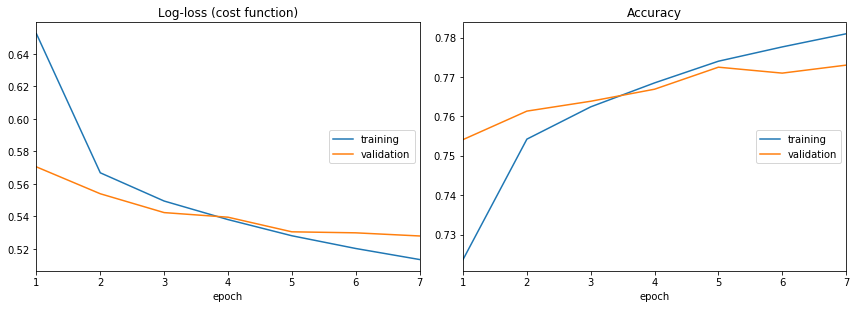

cnn_funnel


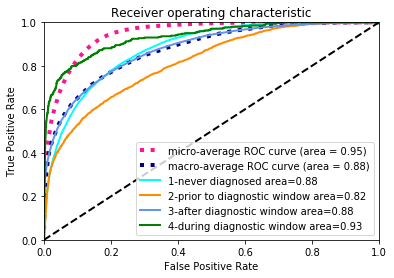

In [56]:
from livelossplot import PlotLossesKeras

y_pred_model={}

for model_name,hyperparameters in model_hyperparameters.items():
    cpu_model,model,embedding_layer=hyperparameters['create_model_function'](x_train,x_train_2,y_train,sg,hyperparameters=hyperparameters)
    
    model.fit([x_train,x_train_2],y_train
          , batch_size=hyperparameters['batch_size']
          , validation_data=([x_dev,x_dev_2],y_dev)
          , callbacks=[PlotLossesKeras()]
          , epochs=hyperparameters['epochs']
          , verbose=2)
    
    y_true=y_dev
    y_pred=model.predict([x_dev,x_dev_2])
    y_pred_model[model_name]=y_pred
    
    print(model_name)
    evaluate(y_true,y_pred)

    np.save('%s/seen_diseases_y_true_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_true)
    np.save('%s/seen_diseases_y_pred_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_pred)
    cpu_model.save('%s/%s_dataset_%s_model_%s.h5' % (results_folder,experiment,dataset,model_name))
    


bilstm


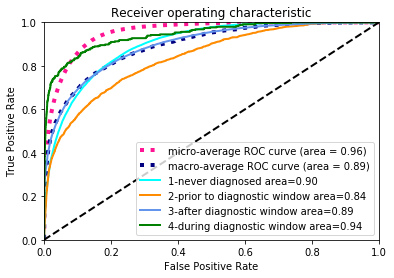

cnn_hierarchical


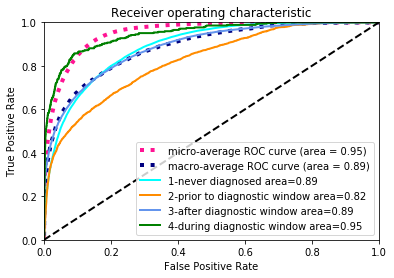

cnn_funnel


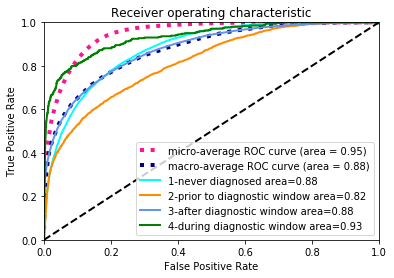

cnn_flat


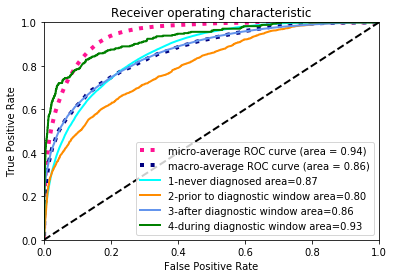

In [57]:
evaluation_types=['data/results/indomain_eval','data/results/withheld_disease_eval']

y_pred_model={}
for model_name,_ in model_hyperparameters.items():
    y_pred_model[model_name]=np.load('%s/seen_diseases_y_pred_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

for model_name,y_pred in y_pred_model.items():
    print(model_name)
    evaluate(y_dev,y_pred)   
    
#y_pred_model={}
#for model_name,_ in model_hyperparameters.items():
#    y_pred_model[model_name]=np.load('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % ('data/results/withheld_disease_eval',experiment,dataset,model_name))

#for model_name,y_pred in y_pred_model.items():
#    print(model_name)
#    evaluate(y_dev,y_pred)   
        

In [38]:
1

1